# Init

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

# Read data

https://www.kaggle.com/datasets/rupakroy/online-payments-fraud-detection-dataset

In [8]:
!kaggle datasets download -d rupakroy/online-payments-fraud-detection-dataset

100%|████████████████████████████████████████| 178M/178M [00:39<00:00, 4.91MB/s]
100%|████████████████████████████████████████| 178M/178M [00:39<00:00, 4.75MB/s]


In [9]:
!unzip online-payments-fraud-detection-dataset.zip

Archive:  online-payments-fraud-detection-dataset.zip
  inflating: PS_20174392719_1491204439457_log.csv  


In [2]:
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [3]:
df.head(10)

step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815      170136.00       160296.36   
1     1   PAYMENT   1864.28  C1666544295       21249.00        19384.72   
2     1  TRANSFER    181.00  C1305486145         181.00            0.00   
3     1  CASH_OUT    181.00   C840083671         181.00            0.00   
4     1   PAYMENT  11668.14  C2048537720       41554.00        29885.86   
5     1   PAYMENT   7817.71    C90045638       53860.00        46042.29   
6     1   PAYMENT   7107.77   C154988899      183195.00       176087.23   
7     1   PAYMENT   7861.64  C1912850431      176087.23       168225.59   
8     1   PAYMENT   4024.36  C1265012928        2671.00            0.00   
9     1     DEBIT   5337.77   C712410124       41720.00        36382.23   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0            0.00        0               0  
1  M2044282225             0.0            0.00        0               0  
2   C553264065             0.0            0.00        1               0  
3    C38997010         21182.0            0.00        1               0  
4  M1230701703             0.0            0.00        0               0  
5   M573487274             0.0            0.00        0               0  
6   M408069119             0.0            0.00        0               0  
7   M633326333             0.0            0.00        0               0  
8  M1176932104             0.0            0.00        0               0  
9   C195600860         41898.0        40348.79        0               0

In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
y_col = "isFraud"

# Correlation Matrix

<AxesSubplot:>

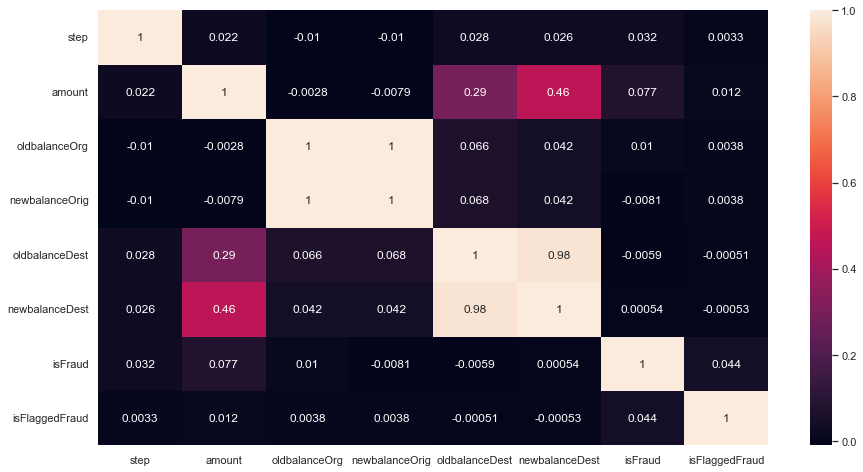

In [6]:
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(df.corr(), annot=True, )

# Target Balance

In [8]:
class_positive = df[df[y_col] == 1].shape[0] 
class_negative = df[df[y_col] == 0].shape[0] 

print("Positive %s" % class_positive)
print("Negative %s" % class_negative)

print("Proportion %s" % str(class_positive/class_negative*100))

Positive 8213
Negative 6354407
Proportion 0.129248881917699


# Features Engineering

<AxesSubplot:ylabel='type'>

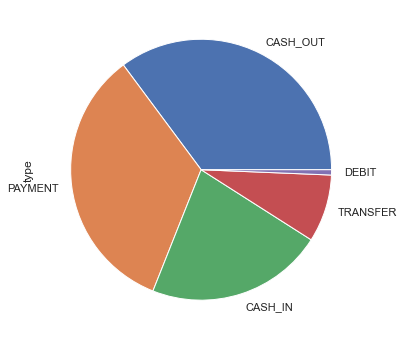

In [9]:
df["type"].value_counts().plot(kind = "pie", figsize = (6,6))

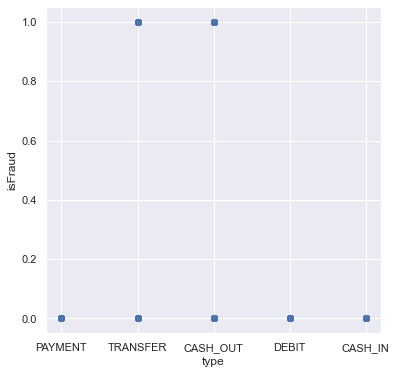

In [10]:
plt.rcParams["figure.figsize"] = (6,6)
plt.scatter(x = 'type', y = 'isFraud', data = df)
plt.xlabel('type')
plt.ylabel('isFraud')
plt.show()

In [11]:
df[(df["type"] == "TRANSFER") & 
   (df["newbalanceOrig"] == 0) &
   (df["oldbalanceOrg"] == df["amount"])
]["isFraud"].value_counts()

1    3933
Name: isFraud, dtype: int64

In [12]:
df[(df["type"] == "CASH_OUT") & 
   (df["newbalanceOrig"] == 0) &
   (df["oldbalanceOrg"] == df["amount"]) &
    (df["isFraud"] == 1) 
]["isFraud"].value_counts()

1    4091
Name: isFraud, dtype: int64

In [13]:
def DataPreprocessing(df_in):
    
    tmp_cols = ['type', 'newbalanceOrig', 'oldbalanceOrg', 'newbalanceDest', 'oldbalanceDest', 'amount']
    
    df_out = df_in[tmp_cols].copy()
    
    # подозрительные переводы
    df_out.loc[(df_out["type"] == "TRANSFER") & 
               (df_out["newbalanceOrig"] == 0) & 
               (df_out["oldbalanceOrg"] == df_out["amount"]), 
               'is_suspicious_transfer'] = 1

    df_out['is_suspicious_transfer'] = df_out['is_suspicious_transfer'].fillna(0).astype('int')
    
    # подозрительный вывод кэша
    df_out.loc[(df_out["type"] == "CASH_OUT") & 
               (df_out["newbalanceOrig"] == 0) & 
               (df_out["oldbalanceOrg"] == df_out["amount"]), 
               'is_suspicious_cash_out'] = 1    
    
    df_out['is_suspicious_cash_out'] = df_out['is_suspicious_cash_out'].fillna(0).astype('int')    
 
    # изменение баланса customer
    df_out['customer_balance_chng'] = df_out['oldbalanceOrg'] - df_out['newbalanceOrig']

    # изменение баланса recipient
    df_out['recipient_balance_chng'] = df_out['oldbalanceDest'] - df_out['newbalanceDest']
    
    for ttype in df['type'].unique().tolist():
        df.loc[(df["type"] == ttype), ttype + '_amount'] = df['amount']
        df[ttype + '_amount'] = df[ttype + '_amount'].fillna(0)
        
    
    df_out.drop(tmp_cols, axis = 1, inplace = True)

    return df_out

# Split Train Test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(y_col, axis = 1), 
                                                    df[y_col], 
                                                    train_size = 0.8, 
                                                    stratify = df[y_col])

# Model

In [15]:
%time

    #Preprocessing
    X_train = DataPreprocessing(X_train)
    X_test = DataPreprocessing(X_test)

    # Classifier
    clf = Pipeline(steps=[("scaler", MinMaxScaler()),
                          ("classifier", LogisticRegression(class_weight = {1 : 100, 0:1}))
                         ]
                  )

    clf.fit(X_train, y_train)

    # Predict
    y_pred = clf.predict(X_test)
    y_pred_proba = clf.predict_proba(X_test)

    # Evaluate
    ll = log_loss(y_test, y_pred_proba)
    f1 = f1_score(y_test, y_pred, average="weighted")
    auc = roc_auc_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    print("Log Loss :%.3f"  %(ll))
    print("ROC AUC :%.3f"  %(auc))
    print("F1 :%.3f"  %(f1))
    print("TN = %i; FP = %i; FN = %i; TP = %i;" %(tn, fp, fn, tp))

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.77 µs
Log Loss :0.001
ROC AUC :0.997
F1 :1.000
TN = 1270881; FP = 0; FN = 10; TP = 1633;
